In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from IPython.display import display, HTML


# Download data

In [2]:
train = pd.read_csv('./train.csv', index_col='id')
test = pd.read_csv('./test.csv', index_col='id')
train['timestamp'] = train['timestamp'].apply(pd.to_datetime)

In [3]:
def num_houses_with_bigger_column_value (column_name, value):
    return len(train[train[column_name] > value].index)

def num_houses_with_less_column_value (column_name, value):
    return len(train[train[column_name] < value].index)

In [4]:
def plot_feature_kde(column_name, min_value, max_value):
    data = train[column_name]
    data = data.where(data.notnull(), axis=0)
    data = data[(min_value <= data) & (data <= max_value)]
    ax = sns.kdeplot(data=data, shade=True)
    ax.set(xlabel= column_name, ylabel='density')

def plot_regplot(column_name1, column_name2, col1_min, col1_max, col2_min, col2_max, alpha=0.1):
    reg_plot_data = train[[column_name1, column_name2]]
    reg_plot_data = reg_plot_data[(col1_min <= train[column_name1]) & (train[column_name1] <= col1_max) \
                                & (col2_min <= train[column_name2]) & (train[column_name2] <= col2_max)]
    sns.regplot(x=reg_plot_data[column_name1], y=reg_plot_data[column_name2], \
              scatter_kws={'alpha':alpha})

def plot_features_jointplot(column_name1, column_name2, col1_min, col1_max, \
                            col2_min, col2_max, alpha=0.1):
    data = train.loc[:, [column_name1, column_name2]]
    data = data[data.notnull().all(axis=1)]
    data = data[(col1_min <= data[column_name1]) & (data[column_name1] <= col1_max) \
              & (col2_min <= data[column_name2]) & (data[column_name2] <= col2_max)]
    sns.jointplot(column_name1, column_name2, data=data, kind="kde", space=0, color="b", \
                scatter_kws={'alpha':alpha})

def plot_lmplot(column_name1, column_name2, hue, col1_min, col1_max, \
                            col2_min, col2_max, alpha=0.1):
    data = train.loc[:, [column_name1, column_name2, hue]]
    data=data[data.notnull().all(axis=1)]
    data = data[(col1_min <= data[column_name1]) & (data[column_name1] <= col1_max) \
              & (col2_min <= data[column_name2]) & (data[column_name2] <= col2_max)]
    sns.lmplot(x=column_name1, y=column_name2, hue=hue, data=data, scatter_kws={'alpha':alpha})

def plot_distplot(column_name):
    sns.distplot(a=train[column_name], kde=False)

## &emsp; Data processing



In [5]:
import math

def change_life_sq (row):
    if row['life_sq'] > 100 and row['life_sq/full_sq'] > 1 / 0.67:
        return row['full_sq']
    elif row['life_sq/full_sq'] > 1 / 0.67:
        return row['life_sq'] - row['full_sq']
    elif row['full_sq'] < row['life_sq']:
        return row['full_sq']
    return row['life_sq']

def change_full_sq (row):
    if row['life_sq'] > 100 and row['life_sq/full_sq'] > 1 / 0.67:
        return row['full_sq']
    elif row['life_sq/full_sq'] > 1.3:
        return row['life_sq']
    elif row['full_sq'] < row['life_sq']:
        return row['life_sq']
    return row['full_sq']

def account_kitch_sq (row):
    if row['kitch_sq'] >= 0 and row['kitch_sq'] < row['full_sq_help']:
        return row['full_sq_help'] - row['kitch_sq']
    return row['life_sq_help']

def custom_pipeline(data_recieved, is_train=True):
    data = data_recieved.copy()
    
    if is_train:
        data.drop(data[data['full_sq'] > 1000].index, inplace=True)
        data.drop(data[data['build_year'] > 2018].index, inplace=True)
        data.drop(data[(data['full_sq'] == 0) & (data['life_sq'] == 0) & (data['kitch_sq'] == 0)].index, \
                  inplace=True)

    mean_division_value = 0.67
    
    data['life_sq/full_sq'] = data['life_sq'] / (data['full_sq'] + 1)
    data['life_sq/full_sq'].mask(np.isinf(data['life_sq/full_sq']), inplace=True)
    data['life_sq/full_sq'].fillna(mean_division_value, inplace=True)

    data.loc[data['life_sq'] > 200, 'life_sq'] = \
                                    data[data['life_sq'] > 200].apply(lambda x: \
                                    x['full_sq'] - x['kitch_sq'] if x['kitch_sq'] >= 0 else x['full_sq'], axis=1)

    mean_value = data['life_sq/full_sq'].mean()
    data['life_sq'] = data.apply(lambda x: x['life_sq'] if not pd.isnull(x['life_sq']) \
                                   else x['full_sq'] * mean_value, axis=1)
    
    data_help = data[['full_sq', 'life_sq', 'kitch_sq', 'life_sq/full_sq']].copy()
    data_help['life_sq_help'] = data_help.apply(change_life_sq, axis=1)
    data_help['full_sq_help'] = data_help.apply(change_full_sq, axis=1)
    data_help['life_sq_help'] = data_help.apply(account_kitch_sq, axis=1)
    data_help['life_sq_help'] = data_help.apply(lambda x: x['life_sq_help'] \
                                if not pd.isnull(x['life_sq_help']) else x['full_sq_help'] * mean_value, axis=1)
    data[['full_sq', 'life_sq']] = data_help[['full_sq_help', 'life_sq_help']]
    data.loc[data['life_sq/full_sq'] > 0.9, 'life_sq'] = \
                    data.loc[data['life_sq/full_sq'] > 0.9].apply(lambda x: x['full_sq'] * mean_value, axis=1)
    
    data.loc[:, 'life_sq'] = data.apply(lambda x: math.ceil(x['life_sq']), axis=1)
    data['life_sq/full_sq'] = (data['life_sq'] + 1) / (data['full_sq'] + 1)
    data['full_sq/life_sq'] = 1 / data['life_sq/full_sq']
    data['kitch_sq'] = data.apply(lambda x: x['full_sq'] - x['life_sq'] , axis = 1)
    data['life_sq/kitch_sq'] = (data['life_sq']) / (data['kitch_sq'] + 1)
    
    data_help = data[['kitch_sq', 'life_sq', 'full_sq', 'life_sq/kitch_sq', 'num_room']].copy()
    data_help['life_sq_help'] = data_help.apply(lambda x: x['kitch_sq'] \
                                        if x['life_sq/kitch_sq'] < x['num_room'] * 1.3 else x['life_sq'], axis=1)
    data_help['kitch_sq_help'] = data_help.apply(lambda x: x['life_sq'] \
                                        if x['life_sq/kitch_sq'] < x['num_room'] * 1.3 else x['kitch_sq'], axis=1)
    data[['life_sq', 'kitch_sq']]= data_help[['life_sq_help', 'kitch_sq_help']]
    
    data['life_sq/full_sq'] = (data['life_sq'] + 1) / (data['full_sq'] + 1)
    data['life_sq/kitch_sq'] = (data['life_sq'] + 1) / (data['kitch_sq'] + 1)
    data['full_sq/life_sq'] = 1 / data['life_sq/full_sq']
    data['kitch_sq/life_sq'] = 1 / data['life_sq/kitch_sq']
    
    data.rename(columns={'kitch_sq' : 'other_sq'}, inplace=True)
    
    data.loc[:, 'full_sq'] = data.apply(lambda x: round(x['full_sq']), axis=1)
    data.loc[:, 'life_sq'] = data.apply(lambda x: round(x['life_sq']), axis=1)
    data.loc[:, 'other_sq'] = data.apply(lambda x: round(x['other_sq']), axis=1)
    
    data.drop(columns=['life_sq/kitch_sq', 'kitch_sq/life_sq'], inplace=True)
    data['life_sq/full_sq'] = (data['life_sq'] + 1) / (data['full_sq'] + 1)
    data['life_sq/other_sq'] = (data['life_sq'] + 1) / (data['other_sq'] + 1)
    data['full_sq/life_sq'] = 1 / data['life_sq/full_sq']
    data['other_sq/life_sq'] = 1 / data['life_sq/other_sq']
    
    sample_data = data[['life_sq', 'other_sq', 'life_sq/other_sq']].copy()
    data.loc[:, 'life_sq'] = sample_data.apply(lambda x: x['life_sq'] if \
                                        x['life_sq/other_sq'] > 0.8 else x['other_sq'], axis=1)
    data.loc[:, 'other_sq'] = sample_data.apply(lambda x: x['other_sq'] if \
                                        x['life_sq/other_sq'] > 0.8 else x['life_sq'], axis=1)
    
    data['life_sq/full_sq'] = (data['life_sq'] + 1) / (data['full_sq'] + 1)
    data['life_sq/other_sq'] = (data['life_sq'] + 1) / (data['other_sq'] + 1)
    data['full_sq/life_sq'] = 1 / data['life_sq/full_sq']
    data['other_sq/life_sq'] = 1 / data['life_sq/other_sq'] 
    
    if is_train:
        data.drop(data[data['full_sq'] > 290].index, inplace=True)
        data.drop(1030, inplace=True)
    
    return data

In [6]:
train = custom_pipeline(train)

## &emsp; floor, max_floor and build_year

In [7]:
train[['floor', 'max_floor']].describe()

,floor,max_floor
count,30285.000000,20891.000000
mean,7.670398,12.558470
std,5.318386,6.755319
min,0.000000,0.000000
25%,3.000000,9.000000
50%,7.000000,12.000000
75%,11.000000,17.000000
max,77.000000,117.000000


In [8]:
train[['floor', 'max_floor']].median()

floor         7.0
max_floor    12.0
dtype: float64

In [9]:
train[['floor', 'max_floor']].isna().sum()

floor         167
max_floor    9561
dtype: int64

/home/sergei/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'scatter_kws'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


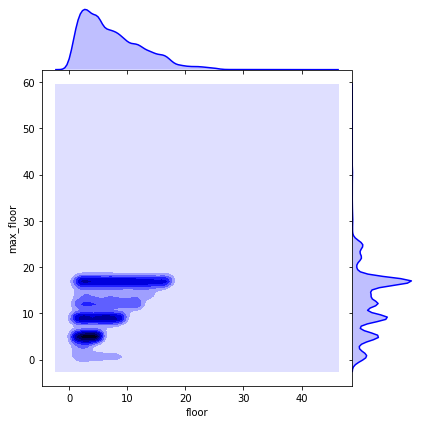

In [10]:
plot_features_jointplot('floor', 'max_floor', 0, 60, 0, 60)

As we can see floors are equally destributed in [0; max_floor].

Also the most popular max_floor values are 5, 9, 12 and 17.

In [11]:
train[train['max_floor'] < train['floor']].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/other_sq,other_sq/life_sq
id,,,,,,,,,,,,,,,,,,,,,
8219,2013-05-29,58,58.0,13.0,0.0,1.0,NaN,2.0,0.0,NaN,...,7,1,0,12,1,5813760,1.000000,1.000000,59.000000,0.016949
8271,2013-05-31,93,60.0,3.0,1.0,1.0,2013.0,3.0,33.0,1.0,...,3,0,0,0,0,5427640,0.648936,1.540984,1.794118,0.557377
8502,2013-06-14,37,37.0,2.0,0.0,1.0,1979.0,1.0,0.0,2.0,...,23,1,0,52,5,6000000,1.000000,1.000000,38.000000,0.026316
8534,2013-06-17,34,26.0,7.0,0.0,6.0,NaN,1.0,8.0,1.0,...,7,1,0,12,1,3842500,0.771429,1.296296,3.000000,0.333333
8915,2013-07-03,51,43.0,5.0,0.0,1.0,1997.0,2.0,8.0,1.0,...,29,1,2,74,11,3850000,0.846154,1.181818,4.888889,0.204545


In [12]:
train[train['max_floor'] < train['floor']].shape[0]

1493

The easiest way to edit this mismatch would be to simply max_floor = floor.
We should also look at interconnection between max_floor and build_year.

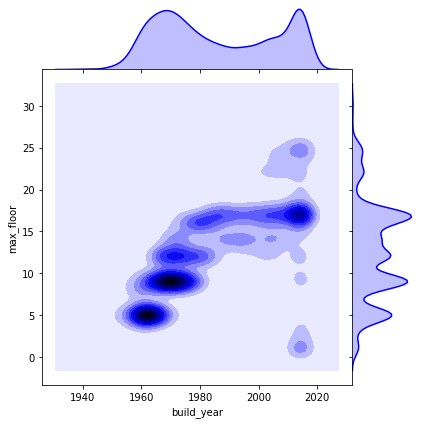

In [13]:
plot_features_jointplot('build_year', 'max_floor', 1940, 2018, 1, 30)

In [14]:
d = dict()
for year in range(1940, 2020, 10):
    print('Year:', year - 10, '-', year, 'median = ', train[(year - 10 <= train['build_year']) \
                                                          & (train['build_year'] < year)]['max_floor'].median())
    d[year] = train[(year - 10 <= train['build_year']) & (train['build_year'] < year)]['max_floor'].median()

Year: 1930 - 1940 median =  5.5
Year: 1940 - 1950 median =  7.0
Year: 1950 - 1960 median =  5.0
Year: 1960 - 1970 median =  8.0
Year: 1970 - 1980 median =  12.0
Year: 1980 - 1990 median =  16.0
Year: 1990 - 2000 median =  16.0
Year: 2000 - 2010 median =  17.0


In [15]:
train[train['build_year'] < 1930]['max_floor'].median()

10.0

That seems extremely strange. Let's fix all the mentioned problems.

In [16]:
train[(pd.isnull(train['build_year']) & (pd.isnull(train['max_floor']) & (pd.isnull(train['floor']))))]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/other_sq,other_sq/life_sq
id,,,,,,,,,,,,,,,,,,,,,
179,2011-10-22,98,63.0,NaN,NaN,NaN,NaN,NaN,35.0,NaN,...,3,0,0,10,0,11500000,0.646465,1.546875,1.777778,0.562500
188,2011-10-24,49,29.0,NaN,NaN,NaN,NaN,NaN,20.0,NaN,...,30,0,7,66,16,8300000,0.600000,1.666667,1.428571,0.700000
196,2011-10-25,37,23.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN,...,32,0,7,69,12,2000000,0.631579,1.583333,1.600000,0.625000
216,2011-10-26,45,27.0,NaN,NaN,NaN,NaN,NaN,18.0,NaN,...,18,1,1,41,5,2825000,0.608696,1.642857,1.473684,0.678571
295,2011-11-05,33,20.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,...,17,0,9,51,11,1000000,0.617647,1.619048,1.500000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9702,2013-08-08,146,94.0,NaN,NaN,NaN,NaN,NaN,52.0,NaN,...,4,0,0,2,1,5571000,0.646259,1.547368,1.792453,0.557895
9730,2013-08-09,82,53.0,NaN,NaN,NaN,NaN,NaN,29.0,NaN,...,7,0,0,3,2,3502000,0.650602,1.537037,1.800000,0.555556
9850,2013-08-15,79,41.0,NaN,NaN,NaN,NaN,NaN,38.0,NaN,...,7,1,0,12,1,6934500,0.525000,1.904762,1.076923,0.928571


In [17]:
def fill_max_floor (row):
    if not pd.isnull(row['build_year']) and row['build_year'] < 1930:
        return 2
    if not pd.isnull(row['max_floor']):
        return row['max_floor']
    if not pd.isnull(row['build_year']) and row['build_year'] > 0:
        dict_year = (row['build_year'] // 10) * 10
        if dict_year < 1930:
            return 2
        else:
            return d[dict_year]
    if not pd.isna(row['floor']):
        if row['floor'] > 16:
            return row['floor']
        if row['floor'] > 12:
            return 16
        if row['floor'] > 8:
            return 12
    return 8

In [18]:
train['max_floor'] = train.apply(lambda x: x['floor'] if x['floor'] > x['max_floor'] else x['max_floor'], axis=1)

In [19]:
train['max_floor'] = train.apply(fill_max_floor, axis=1)

In [20]:
train[pd.isnull(train['floor'])].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/other_sq,other_sq/life_sq
id,,,,,,,,,,,,,,,,,,,,,
179,2011-10-22,98,63.0,NaN,8.0,NaN,NaN,NaN,35.0,NaN,...,3,0,0,10,0,11500000,0.646465,1.546875,1.777778,0.562500
188,2011-10-24,49,29.0,NaN,8.0,NaN,NaN,NaN,20.0,NaN,...,30,0,7,66,16,8300000,0.600000,1.666667,1.428571,0.700000
196,2011-10-25,37,23.0,NaN,8.0,NaN,NaN,NaN,14.0,NaN,...,32,0,7,69,12,2000000,0.631579,1.583333,1.600000,0.625000
216,2011-10-26,45,27.0,NaN,8.0,NaN,NaN,NaN,18.0,NaN,...,18,1,1,41,5,2825000,0.608696,1.642857,1.473684,0.678571
295,2011-11-05,33,20.0,NaN,8.0,NaN,NaN,NaN,13.0,NaN,...,17,0,9,51,11,1000000,0.617647,1.619048,1.500000,0.666667


In [21]:
train[train['floor'] > train['max_floor']].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/other_sq,other_sq/life_sq
id,,,,,,,,,,,,,,,,,,,,,
8936,2013-07-04,106,98.0,4.0,2.0,2.0,1917.0,5.0,8.0,2.0,...,241,2,102,196,13,22800000,0.925234,1.080808,11.000000,0.090909
9444,2013-07-25,73,47.0,5.0,2.0,1.0,0.0,3.0,26.0,NaN,...,7,0,0,6,0,5626933,0.648649,1.541667,1.777778,0.562500
9623,2013-08-05,65,64.0,7.0,2.0,1.0,1.0,2.0,1.0,1.0,...,9,0,0,38,4,5415070,0.984848,1.015385,32.500000,0.030769
9703,2013-08-08,60,59.0,24.0,2.0,1.0,1.0,2.0,1.0,1.0,...,7,0,0,6,0,5402275,0.983607,1.016667,30.000000,0.033333
9748,2013-08-09,39,26.0,10.0,2.0,1.0,1.0,1.0,13.0,1.0,...,3,0,0,6,1,3984760,0.675000,1.481481,1.928571,0.518519


In [22]:
train['build_year'].nunique()

117

In [23]:
train[(0 < train['build_year']) & (train['build_year'] < 1930)]['build_year'].value_counts().sort_index()

1.0       368
3.0         2
20.0        1
71.0        1
215.0       1
1691.0      1
1860.0      2
1876.0      1
1886.0      1
1890.0      5
1895.0      1
1896.0      2
1900.0      2
1904.0      1
1905.0      1
1906.0      1
1907.0      2
1910.0      5
1911.0      1
1912.0      5
1914.0      3
1915.0      5
1917.0     16
1920.0      1
1924.0      3
1925.0      1
1926.0      8
1927.0     10
1928.0     12
1929.0     12
Name: build_year, dtype: int64

As we can see, we have some strange build_year values like 1, 3, 20, 71 etc.

In [24]:
train['build_year'].isna().sum() + len(train[train['build_year'] < 1860].index)

14494

In [25]:
train[train['build_year'] > 1860]['build_year'].describe()

count    15956.000000
mean      1985.381988
std         20.819634
min       1876.000000
25%       1968.000000
50%       1981.000000
75%       2006.000000
max       2018.000000
Name: build_year, dtype: float64

In [26]:
train.loc[train['build_year'] < 1860, 'build_year'] = np.nan

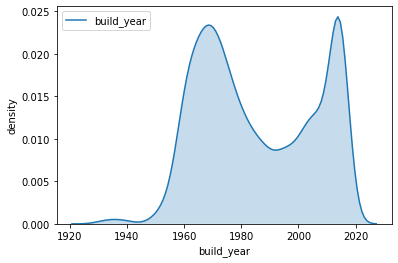

In [27]:
plot_feature_kde('build_year', 1930, 2018)

In my opnion the best option would be to Impute build_year column and keep track of Imputed values. (Otherwise we'll ruin the destribution).

In [28]:
my_build_Imputer = SimpleImputer(strategy="median")

def impute_build_year(train):
    train['build_year was_missing'] = train[['build_year']].isnull() 
    my_build_Imputer.fit(train[['build_year']])
    train.loc[:, 'build_year'] = my_build_Imputer.transform(train[['build_year']])

In [29]:
impute_build_year(train)

In [30]:
train.head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,...,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/other_sq,other_sq/life_sq,build_year was_missing
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,8.0,NaN,1981.0,NaN,16.0,NaN,...,1,0,52,4,5850000,0.636364,1.571429,1.647059,0.607143,True
2,2011-08-23,34,19.0,3.0,8.0,NaN,1981.0,NaN,15.0,NaN,...,1,10,66,14,6000000,0.571429,1.750000,1.250000,0.800000,True
3,2011-08-27,43,29.0,2.0,8.0,NaN,1981.0,NaN,14.0,NaN,...,0,4,67,10,5700000,0.681818,1.466667,2.000000,0.500000,True
4,2011-09-01,89,50.0,9.0,12.0,NaN,1981.0,NaN,39.0,NaN,...,0,0,26,3,13100000,0.566667,1.764706,1.275000,0.784314,True
5,2011-09-05,77,50.0,4.0,8.0,NaN,1981.0,NaN,27.0,NaN,...,2,91,195,14,16331452,0.653846,1.529412,1.821429,0.549020,True


In [31]:
train.loc[:, ['floor', 'max_floor']].isna().sum().sum()

167

In [32]:
train['floor'].isna().sum()

167

In [33]:
train['floor was_missing'] = train['floor'].isnull()

In [34]:
train['floor'] = train.apply(lambda x: x['max_floor'] // 2 if pd.isnull(x['floor']) \
                             else x['floor'], axis=1)

# Strange features analysis

In [35]:
train.columns[train.isna().sum() > 0]

Index(['material', 'num_room', 'state', 'preschool_quota', 'school_quota',
       'hospital_beds_raion', 'raion_build_count_with_material_info',
       'build_count_block', 'build_count_wood', 'build_count_frame',
       'build_count_brick', 'build_count_monolith', 'build_count_panel',
       'build_count_foam', 'build_count_slag', 'build_count_mix',
       'raion_build_count_with_builddate_info', 'build_count_before_1920',
       'build_count_1921-1945', 'build_count_1946-1970',
       'build_count_1971-1995', 'build_count_after_1995', 'metro_min_walk',
       'metro_km_walk', 'railroad_station_walk_km',
       'railroad_station_walk_min', 'ID_railroad_station_walk',
       'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
       'cafe_avg_price_500', 'cafe_sum_1000_min_price_avg',
       'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
       'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
       'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg',
     

In [36]:
strange_columns = []

for column in train.columns:
    if ('max' in train[column].describe().index and  train[column].describe()['max'] > \
        train[column].describe()['mean'] + 10 * train[column].describe()['std']) \
    or ('min' in train[column].describe().index and train[column].describe()['min'] < \
        train[column].describe()['mean'] - 10 * train[column].describe()['std']):
        strange_columns.append(column)

In [50]:
len(strange_columns)

49

In [37]:
train[strange_columns].describe().iloc[:, :10]

,full_sq,life_sq,floor,max_floor,num_room,metro_km_avto,kindergarten_km,school_km,park_km,industrial_km
count,30452.000000,30452.000000,30452.000000,30452.000000,20891.000000,30452.000000,30452.000000,30452.000000,30452.000000,30452.000000
mean,53.861750,42.173979,7.650269,12.027486,1.909770,3.701976,0.981955,1.324478,3.100501,0.768711
std,21.085174,19.289636,5.310705,5.871228,0.851347,5.809256,2.122556,3.059020,3.965643,0.717903
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000470,0.000000,0.003737,0.000000
25%,38.000000,28.000000,3.000000,8.000000,1.000000,1.036568,0.199993,0.269716,0.973297,0.288289
50%,49.000000,39.000000,6.000000,12.000000,2.000000,1.783924,0.353762,0.474873,1.804404,0.576344
75%,63.000000,51.000000,11.000000,17.000000,2.000000,3.776836,0.971417,0.886664,3.404787,1.040965
max,275.000000,249.000000,77.000000,117.000000,19.000000,74.905763,29.085774,47.394706,47.351538,14.048162


In [38]:
train[strange_columns].describe().iloc[:, 10:17]

,public_transport_station_km,public_transport_station_min_walk,ts_km,market_shop_km,fitness_km,swim_pool_km,hospice_morgue_km
count,30452.000000,30452.000000,30452.000000,30452.000000,30452.000000,30452.000000,30452.000000
mean,0.414275,4.971297,4.931685,3.959222,1.154773,4.232998,2.647186
std,1.272871,15.274446,4.804738,3.448221,1.541777,4.627126,2.953116
min,0.002804,0.033646,0.000000,0.003847,0.000000,0.000000,0.002517
25%,0.101312,1.215747,2.057437,1.543631,0.361170,1.709065,1.119195
50%,0.160277,1.923323,3.972224,2.927759,0.656144,2.876573,1.897017
75%,0.278376,3.340516,5.551934,5.485984,1.333994,5.369801,3.298300
max,17.413002,208.956022,54.080913,41.103651,26.652505,53.359294,43.694640


In [39]:
train[strange_columns].describe().iloc[:, 17:24]

,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,additional_education_km,preschool_km,big_church_km
count,30452.000000,30452.000000,30452.000000,30452.000000,30452.000000,30452.000000,30452.000000
mean,3.357383,6.856806,3.927103,1.506136,1.328762,1.345745,2.330448
std,4.342898,6.732483,4.908716,2.254331,1.526600,3.054478,2.987702
min,0.000000,0.000313,0.000000,0.000000,0.000000,0.000000,0.004072
25%,1.279238,2.201870,1.016728,0.483880,0.474687,0.285055,0.860441
50%,2.341633,4.339026,2.030911,0.839691,0.899314,0.493225,1.490777
75%,3.983903,9.380269,5.413674,1.549818,1.571116,0.936324,2.922658
max,76.055135,84.862148,55.278225,26.259543,24.268209,47.394706,45.669060


In [40]:
train[strange_columns].describe().iloc[:, 24:32]

,church_synagogue_km,theater_km,catering_km,office_count_500,office_sqm_500,trc_sqm_500,cafe_count_500,cafe_count_500_price_500
count,30452.000000,30452.000000,30452.000000,30452.000000,30452.000000,3.045200e+04,30452.000000,30452.000000
mean,0.972018,9.639209,0.688025,0.740805,13985.608827,2.179273e+04,3.870452,0.993334
std,0.749006,7.112307,0.833053,2.283373,42616.288434,8.156373e+04,11.280570,3.059542
min,0.000000,0.026788,0.000357,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.532384,4.225254,0.208621,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,0.859724,8.612007,0.412701,0.000000,0.000000,0.000000e+00,1.000000,0.000000
75%,1.248556,13.459593,0.841056,0.000000,0.000000,1.200000e+02,3.000000,1.000000
max,15.615728,87.600690,12.162697,34.000000,611015.000000,1.500000e+06,120.000000,33.000000


In [41]:
train[strange_columns].describe().iloc[:, 32:37]

,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high
count,30452.000000,30452.000000,30452.000000,30452.000000,30452.000000
mean,0.979837,0.843557,0.542624,0.138579,0.029391
std,2.268312,2.318069,2.136608,0.689035,0.182184
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,39.000000,29.000000,22.000000,14.000000,3.000000


In [42]:
train[strange_columns].describe().iloc[:, 37:43]

,mosque_count_500,leisure_count_500,office_sqm_1000,cafe_count_1000_price_1000,cafe_count_1000_price_2500,cafe_count_1000_price_high
count,30452.000000,30452.000000,3.045200e+04,30452.000000,30452.000000,30452.000000
mean,0.004893,0.070570,6.226498e+04,3.941055,1.949921,0.060160
std,0.069779,0.386437,1.438501e+05,9.195899,7.506989,0.332561
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000
75%,0.000000,0.000000,5.450000e+04,4.000000,1.000000,0.000000
max,1.000000,9.000000,2.244723e+06,107.000000,79.000000,7.000000


In [43]:
train[strange_columns].describe().iloc[:, 43:49]

,big_church_count_1000,leisure_count_1000,cafe_count_1500_price_high,leisure_count_1500,price_doc,life_sq/other_sq
count,30452.000000,30452.000000,30452.000000,30452.000000,3.045200e+04,30452.000000
mean,0.810653,0.469066,0.193616,0.945225,7.122116e+06,8.442545
std,2.491892,1.819783,0.907723,3.346804,4.773399e+06,13.700109
min,0.000000,0.000000,0.000000,0.000000,1.000000e+05,0.803922
25%,0.000000,0.000000,0.000000,0.000000,4.740002e+06,1.812500
50%,0.000000,0.000000,0.000000,0.000000,6.275474e+06,3.857143
75%,1.000000,0.000000,0.000000,1.000000,8.300000e+06,6.666667
max,27.000000,30.000000,12.000000,44.000000,1.111111e+08,170.000000


# Num_room

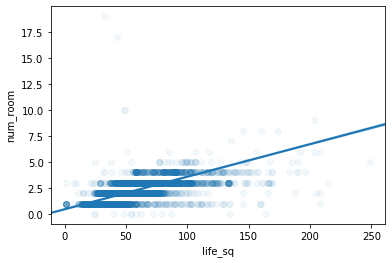

In [51]:
sns.regplot(x=train['life_sq'], y=train['num_room'], scatter_kws={'alpha':0.05})

In [52]:
train.loc[:, 'num_room was missing'] = train['num_room'].isnull()

In [53]:
train.loc[train['num_room'].isnull(), 'num_room'] = np.round(train.loc[train['num_room'].isnull(), 'life_sq'] / 23)

In [54]:
strange_subareas = list(set(train[(train['kindergarten_km'] > 10) | (train['school_km'] > 10) | \
                  (train['park_km'] > 10) | (train['public_transport_station_km'] > 10)]['sub_area'].values))

In [55]:
for area in strange_subareas:
    print(train.loc[train['sub_area'] == area, ['kindergarten_km', 'school_km', 'park_km', \
                                            'public_transport_station_km']].describe())

       kindergarten_km  school_km    park_km  public_transport_station_km
count        92.000000  92.000000  92.000000                    92.000000
mean          1.495999   0.364635  16.213606                     0.214015
std           0.247831   0.176009   0.284205                     0.108861
min           1.065537   0.095827  15.651085                     0.039915
25%           1.259465   0.215246  16.046012                     0.130775
50%           1.483170   0.364420  16.226019                     0.217776
75%           1.671978   0.484469  16.453366                     0.285523
max           2.014353   0.749390  16.671256                     0.501470
       kindergarten_km  school_km    park_km  public_transport_station_km
count         7.000000   7.000000   7.000000                     7.000000
mean          0.257026   0.249163   4.847943                     0.346386
std           0.085826   0.111655   4.090694                     0.448313
min           0.139293   0.108849   2.

       kindergarten_km   school_km     park_km  public_transport_station_km
count       496.000000  496.000000  496.000000                   496.000000
mean          1.216930    6.611728   11.503558                     3.578772
std           1.159000    1.175666    1.086023                     0.840971
min           0.006244    2.753517    9.414271                     1.124417
25%           0.080555    5.222637   10.402779                     2.734467
50%           0.530688    7.465533   12.154481                     4.038483
75%           2.313382    7.465533   12.535910                     4.383929
max           3.450735    7.872947   12.855459                     4.857385
       kindergarten_km   school_km     park_km  public_transport_station_km
count       158.000000  158.000000  158.000000                   158.000000
mean          0.411868   14.027049   15.208300                     0.237233
std           0.295656    0.988528    0.827759                     0.149064
min         

Strangely enough all this data is correct according to sub area location and whole dataframe info

In [56]:
train.columns[train.isna().sum() > 0]

Index(['material', 'state', 'preschool_quota', 'school_quota',
       'hospital_beds_raion', 'raion_build_count_with_material_info',
       'build_count_block', 'build_count_wood', 'build_count_frame',
       'build_count_brick', 'build_count_monolith', 'build_count_panel',
       'build_count_foam', 'build_count_slag', 'build_count_mix',
       'raion_build_count_with_builddate_info', 'build_count_before_1920',
       'build_count_1921-1945', 'build_count_1946-1970',
       'build_count_1971-1995', 'build_count_after_1995', 'metro_min_walk',
       'metro_km_walk', 'railroad_station_walk_km',
       'railroad_station_walk_min', 'ID_railroad_station_walk',
       'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
       'cafe_avg_price_500', 'cafe_sum_1000_min_price_avg',
       'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
       'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
       'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg',
       'cafe_sum_

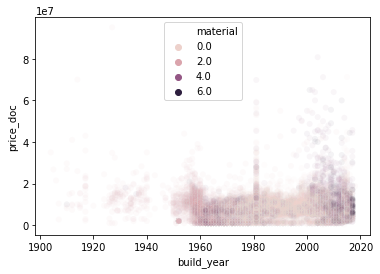

In [57]:
sns.scatterplot(x='build_year', y='price_doc', hue='material', data=train[train['build_year'] > 1900], alpha=0.05)

In [58]:
train.loc[pd.isnull(train['material']), ['full_sq', 'life_sq', 'build_year','num_room']].describe()

,full_sq,life_sq,build_year,num_room
count,9561.000000,9561.000000,9561.0,9561.000000
mean,52.902102,32.700031,1981.0,1.418053
std,21.680083,14.454118,0.0,0.655045
min,6.000000,4.000000,1981.0,0.000000
25%,38.000000,22.000000,1981.0,1.000000
50%,47.000000,30.000000,1981.0,1.000000
75%,62.000000,40.000000,1981.0,2.000000
max,226.000000,142.000000,1981.0,6.000000


In [59]:
train.loc[pd.isnull(train['material']), 'build_year was_missing'].shape[0] - \
train.loc[pd.isnull(train['material']), 'build_year was_missing'].sum()

0

It seems like all the houses with unknown material previously had build_year = NAN

In [60]:
train.loc[:, 'material'].fillna(7, inplace=True)

In [61]:
train['state'].isna().sum()

13545

In [62]:
train[pd.isnull(train['state'])].describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,area_m,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/other_sq,other_sq/life_sq
count,13545.000000,13545.000000,13545.000000,13545.000000,13545.000000,13545.000000,13545.000000,13545.000000,0.0,1.354500e+04,...,13545.000000,13545.000000,13545.000000,13545.000000,13545.000000,1.354500e+04,13545.000000,13545.000000,13545.000000,13545.000000
mean,53.840384,38.220967,8.038686,11.422222,5.409376,1981.547804,1.541676,15.619417,NaN,2.019312e+07,...,28.068955,0.456700,7.753710,47.213141,5.213215,6.476387e+06,0.707870,1.474840,8.711563,0.505428
std,21.349296,18.562290,5.408967,5.202204,2.569515,6.834337,0.725797,10.603145,NaN,2.202085e+07,...,46.772444,0.607886,20.308315,46.288758,4.785569,4.431768e+06,0.154859,0.290231,16.999513,0.298022
min,6.000000,4.000000,0.000000,1.000000,1.000000,1890.000000,0.000000,0.000000,NaN,2.081628e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.900000e+05,0.450549,1.000000,0.803922,0.005882
25%,38.000000,26.000000,4.000000,8.000000,2.000000,1981.000000,1.000000,9.000000,NaN,7.587523e+06,...,7.000000,0.000000,0.000000,9.000000,1.000000,4.371459e+06,0.606061,1.219512,1.461538,0.250000
50%,49.000000,34.000000,7.000000,8.000000,7.000000,1981.000000,1.000000,16.000000,NaN,1.139168e+07,...,14.000000,0.000000,1.000000,37.000000,4.000000,5.744772e+06,0.656250,1.523810,1.812500,0.551724
75%,63.000000,46.000000,12.000000,16.000000,7.000000,1981.000000,2.000000,21.000000,NaN,2.553630e+07,...,26.000000,1.000000,5.000000,71.000000,9.000000,7.400000e+06,0.820000,1.650000,4.000000,0.684211
max,226.000000,189.000000,44.000000,99.000000,7.000000,2017.000000,6.000000,103.000000,NaN,2.060718e+08,...,250.000000,2.000000,105.000000,218.000000,20.000000,1.111111e+08,1.000000,2.219512,170.000000,1.243902


House's state is a parameter, that can't be related to any other parameter of the house, so the best option is to make a mark that it was missing

In [63]:
missed_features = np.array(['preschool_quota', 'school_quota',
       'hospital_beds_raion', 'raion_build_count_with_material_info',
       'build_count_block', 'build_count_wood', 'build_count_frame',
       'build_count_brick', 'build_count_monolith', 'build_count_panel',
       'build_count_foam', 'build_count_slag', 'build_count_mix',
       'raion_build_count_with_builddate_info', 'build_count_before_1920',
       'build_count_1921-1945', 'build_count_1946-1970',
       'build_count_1971-1995', 'build_count_after_1995', 'metro_min_walk',
       'metro_km_walk', 'railroad_station_walk_km',
       'railroad_station_walk_min', 'ID_railroad_station_walk',
       'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
       'cafe_avg_price_500', 'cafe_sum_1000_min_price_avg',
       'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
       'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
       'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg',
       'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000',
       'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
       'cafe_avg_price_3000', 'prom_part_5000', 'cafe_sum_5000_min_price_avg',
       'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000'])

In [64]:
train[missed_features].isna().sum()

preschool_quota                           6687
school_quota                              6684
hospital_beds_raion                      14436
raion_build_count_with_material_info      4990
build_count_block                         4990
build_count_wood                          4990
build_count_frame                         4990
build_count_brick                         4990
build_count_monolith                      4990
build_count_panel                         4990
build_count_foam                          4990
build_count_slag                          4990
build_count_mix                           4990
raion_build_count_with_builddate_info     4990
build_count_before_1920                   4990
build_count_1921-1945                     4990
build_count_1946-1970                     4990
build_count_1971-1995                     4990
build_count_after_1995                    4990
metro_min_walk                              25
metro_km_walk                               25
railroad_stat

In [65]:
for feature in missed_features:
    train[feature + ' was missing'] = train[feature].isnull()
    for area in set(train['sub_area'].values):
        train.loc[(train['sub_area'] == area) & (pd.isnull(train[feature])), feature] = \
        train[(train['sub_area'] == area) & (~pd.isnull(train[feature]))][feature].median()

In [66]:
train[missed_features].isna().sum()

preschool_quota                           6687
school_quota                              6684
hospital_beds_raion                      14436
raion_build_count_with_material_info      4990
build_count_block                         4990
build_count_wood                          4990
build_count_frame                         4990
build_count_brick                         4990
build_count_monolith                      4990
build_count_panel                         4990
build_count_foam                          4990
build_count_slag                          4990
build_count_mix                           4990
raion_build_count_with_builddate_info     4990
build_count_before_1920                   4990
build_count_1921-1945                     4990
build_count_1946-1970                     4990
build_count_1971-1995                     4990
build_count_after_1995                    4990
metro_min_walk                               0
metro_km_walk                                0
railroad_stat

I don't see a reasonable way to recover these values so the best option is to fill in the values with imputer.